In [71]:
import re
import string
import itertools
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from collections import Counter

# Download nltk data
nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import twitter_samples 
from nltk.corpus import wordnet
from nltk.tag import pos_tag_sents

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [109]:
df = pd.read_csv('NLP_Prueba_2.csv') #cargamos los datos 
df.head()


,Unnamed: 0,text,tag
0,0,"in exotica everybody is watching , and what is...",pos
1,1,some of the gags are so carefully innocuous th...,neg
2,2,press junkets are a haven for control freaks .,neg
3,3,"then i realized he was , and i was watching it .",neg
4,4,uh huh .,neg


In [110]:
df = df.rename(columns = {'Unnamed: 0': 'id'})
df.head()


,id,text,tag
0,0,"in exotica everybody is watching , and what is...",pos
1,1,some of the gags are so carefully innocuous th...,neg
2,2,press junkets are a haven for control freaks .,neg
3,3,"then i realized he was , and i was watching it .",neg
4,4,uh huh .,neg


In [111]:
df = df.set_index('id')
df.head()

,text,tag
id,,
0,"in exotica everybody is watching , and what is...",pos
1,some of the gags are so carefully innocuous th...,neg
2,press junkets are a haven for control freaks .,neg
3,"then i realized he was , and i was watching it .",neg
4,uh huh .,neg


In [112]:
df.text.head(10)

id
0    in exotica everybody is watching , and what is...
1    some of the gags are so carefully innocuous th...
2       press junkets are a haven for control freaks .
3     then i realized he was , and i was watching it .
4                                             uh huh .
5    and my god , couldn't they have done something...
6    cage , sinise , and yes , even de palma deserv...
7    they are like a couple of kids out exploring t...
8    " idle hands " is bad , no matter the circumst...
9    in this case , the object of darryl's amor is ...
Name: text, dtype: object

In [113]:
df.text.tail(10) #Se puede decir que los datos corresponden a reviews de una película

id
29400    the national alliance for the mentally ill eve...
29401    aside from a brief glimpse of erotic encounter...
29402    they're on this caribbean cruise for pleasure ...
29403      wouldn't the flames burn off the fingerprints ?
29404    the answer is a sick-and-twisted yes - and vie...
29405    roro ( nicknamed " jalla " ) is having family ...
29406                  in three days time , or something .
29407    director nicholas hytner is guilty of encourag...
29408        neighbor runs a small failing grocery store .
29409    what i admire most about city of angels is its...
Name: text, dtype: object

In [114]:
df.text[0] #Se puede observar el primer review de los datos completo

'in exotica everybody is watching , and what is worse , everybody knows .'

In [115]:
df.text[29409] #Se puede observar el último review de los datos completo

'what i admire most about city of angels is its overall presentation .'

In [116]:
df.shape #Se tienen en total 29410 reviews 

(29410, 2)

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29410 entries, 0 to 29409
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    29393 non-null  object
 1   tag     29402 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [194]:
df.isnull().sum()

text        0
tag         8
find_url    0
dtype: int64

In [118]:
df.text = df.text.astype(str)

Vamos a usar la etiqueta que tienen los datos para ver cómo lucen los comentarios positivos y los negativos

In [119]:
pos_reviews = df.text[df.tag == 'pos']
pos_reviews = pos_reviews.reset_index(drop= True)
pos_reviews.head(10)

0    in exotica everybody is watching , and what is...
1    they are like a couple of kids out exploring t...
2    unfortunately , sandler is going to make a lot...
3    the most amusing harbinger of doom : john denv...
4                         it's quite touching really .
5    washington's subdued approach is part of the r...
6    but jordan succeeds at what i consider the tri...
7           it is nothing short of stunning visually .
8    on the granger movie gauge of 1 to 10 , " osmo...
9    lawrence quickly sees just how caring and grea...
Name: text, dtype: object

In [120]:
print('Total de comentarios Positivos:',len(pos_reviews))

Total de comentarios Positivos: 3968


In [121]:
neg_reviews = df.text[df.tag == 'neg']
neg_reviews = neg_reviews.reset_index(drop= True)
neg_reviews.head(10)

0    some of the gags are so carefully innocuous th...
1       press junkets are a haven for control freaks .
2     then i realized he was , and i was watching it .
3                                             uh huh .
4    and my god , couldn't they have done something...
5    cage , sinise , and yes , even de palma deserv...
6    " idle hands " is bad , no matter the circumst...
7    in this case , the object of darryl's amor is ...
8    surprising really , when the effects are done ...
9    incidentally , if you're afraid i'm giving too...
Name: text, dtype: object

In [122]:
print('Total de comentarios Negativos:',len(neg_reviews))

Total de comentarios Negativos: 25434


Importante resaltar que se tiene más comentarios negarivos que positivos, también se puede visualizar en el siguiente gráfico:


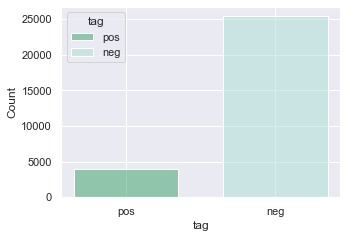

In [123]:
plt.figure(figsize=(5,3.5)) 
sns.set() 
sns.histplot(data=df, x='tag', palette="BuGn_r", hue = 'tag', shrink=.7)

Adicionalmente, sería bueno ver es el tamaño de los comentarios y ver cuál es el más pequeño y cual es el más grande, pero no en total de caracteres si no de tokens. Es decir, se va usar el método de tokenización (con la función de la librería `nltk` llamada `nltk.word_tokenize()`que consiste en dividir nuestra cadena de texto (comentario) en una lista de palabras individuales que usualmente se llaman tokens 

In [135]:
AllReviews = df.text
review_words_lengths = AllReviews.apply(lambda x: len(nltk.word_tokenize(x)))

min(review_words_lengths)

1

In [152]:
AllReviews[review_words_lengths[review_words_lengths == 1].index] #obteniendo todos los comentarios con 1 token

id
319      nan
379        .
565        .
568        ,
1019       .
        ... 
27263    nan
27913      .
27968      .
29030      .
29043    nan
Name: text, Length: 92, dtype: object

Al observar los comentarios con 1 token, se evidencia que hay reviews vacios y otros con solo puntos, por lo que habrá que eliminarlos más adelante.

In [142]:
print(AllReviews[29043], '\n') 
print(AllReviews[27913]) 

nan 

.


In [147]:
max(review_words_lengths) #Comentario con mayor número de tokens

183

In [151]:
AllReviews[review_words_lengths[review_words_lengths == max(review_words_lengths)].index]

id
23995    since that plot is incredibly lame and a track...
Name: text, dtype: object

In [155]:
print(AllReviews[23995])

since that plot is incredibly lame and a track record of what goes on with it wouldn't be able to carry a commercial let alone a feature film , and because it's a party , there are some more main characters , such as : william ( charlie korsmo , finally surfacing after " dick tracy " ) , the nerd ( and his dominions ) who has come up with a ridiculous plan to publically sabotage mike , who's humiliated him for years , but gets too caught up in drinking to do it ; kenny ( seth green ) , the wigger , who has decided that this party will be where he will finally get laid ( uh huh ) ; and denise , the only exceptional character , who unfortunately gets stuck in a bathroom ( don't ask ) with kenny where the two characters let down their characters and are allowed to follow the laws of plot cliches from point a to point b with nary a bit of characterization involved after awhile .


## Pre procesamiento de los datos

Un punto clave antes de pasar a crear el modelo es el pre proceesamiento de los datos porque es necesario depurarlos antes de hacer uso de ellos y muchos de esos métodos incluyen:

- Estandarizar el texto: Minúsculas/Mayúsculas
- Remover espacios extra
- Eliminar URL's

Cuando los datos provienen de redes sociales es de vital importancia realizar el debido pre procesamiento de los datos ya que muchos contienen hashtags, links, emoticones, entre otros. 

Y aunque este no es el caso de nuestros datos porque como se dijo anteriormente pertenecen alguna página de reviews sobre películas o contenido se van realizar ciertos métodoss  pre procesamiento para garantizar que los datos estén idóneos para la creación del modelo. 

1. Para este ejercicio se estandarizan todos los comentarios en letras mínusculas haciendo uso de la función `str.lower()`. Cabe mencionar que el las vistas de los datos que se mostraron anteriormente se puede ver que al parecer todos los reviews están en letras minúsculas pero para asegurarse es mejor realizar la estandarización.


In [124]:
def convert_lowercase(reviews):
    return reviews.lower()

df['text'] = df['text'].apply(lambda k: convert_lowercase(k))

df.head(10)

,text,tag
id,,
0,"in exotica everybody is watching , and what is...",pos
1,some of the gags are so carefully innocuous th...,neg
2,press junkets are a haven for control freaks .,neg
3,"then i realized he was , and i was watching it .",neg
4,uh huh .,neg
5,"and my god , couldn't they have done something...",neg
6,"cage , sinise , and yes , even de palma deserv...",neg
7,they are like a couple of kids out exploring t...,pos
8,""" idle hands "" is bad , no matter the circumst...",neg


2. Se remueven espacios extra tanto antes del texto como después con la función $strip()$.

In [125]:
def remove_whitespaces(reviews):
    return reviews.strip()

df['text'] = df['text'].apply(lambda k: remove_whitespaces(k))

df.head(10)

,text,tag
id,,
0,"in exotica everybody is watching , and what is...",pos
1,some of the gags are so carefully innocuous th...,neg
2,press junkets are a haven for control freaks .,neg
3,"then i realized he was , and i was watching it .",neg
4,uh huh .,neg
5,"and my god , couldn't they have done something...",neg
6,"cage , sinise , and yes , even de palma deserv...",neg
7,they are like a couple of kids out exploring t...,pos
8,""" idle hands "" is bad , no matter the circumst...",neg


3. A continuación se van a buscar comentarios que contengan URL's o links que no van a aportar nada a nuestro análisis

In [173]:
def find_url(reviews):
    return reviews.find('http')

df['find_url'] = df['text'].apply(lambda k: find_url(k))
df.head(10)

,text,tag,find_url
id,,,
0,"in exotica everybody is watching , and what is...",pos,-1
1,some of the gags are so carefully innocuous th...,neg,-1
2,press junkets are a haven for control freaks .,neg,-1
3,"then i realized he was , and i was watching it .",neg,-1
4,uh huh .,neg,-1
5,"and my god , couldn't they have done something...",neg,-1
6,"cage , sinise , and yes , even de palma deserv...",neg,-1
7,they are like a couple of kids out exploring t...,pos,-1
8,""" idle hands "" is bad , no matter the circumst...",neg,-1


In [174]:
df['find_url'].value_counts()

-1     29408
 40        1
 90        1
Name: find_url, dtype: int64

Y según el conteo que se hizo, vemos que hay 29408 de los comentarios que no contienen links y dos de ellos que si contienen direcciones de páginas web. Por lo que hay que identificarlos y proceder a eliminarlos del comentario.


Tal como se encontró anteriormente el comentario con mayor número de tokens es el identificado como $23995$ con $183$ tokens pero necesitamos saber cuántos caracteres en total tiene para así defenir un rango como se muestra en la siguiente línea

In [156]:
print(len(AllReviews[23995])) #un total de 887 caracteres

887


In [157]:
with_url = range(887) 
match_url = df[df['find_url'].isin(with_url)] 
match_url.head(10)

,text,tag,find_url
id,,,
7213,reviewed by brandon herring 4/29/00 for more r...,neg,90
23407,it's a worrying fact when the website ( http :...,neg,40


In [164]:
print(AllReviews[7213], '\n')
print(AllReviews[23407])

reviewed by brandon herring 4/29/00 for more reviews please visit movie review central at http : //www . geocities . com/moviefan983/moviereviewcentral . html 

it's a worrying fact when the website ( http : //www . blairwitch . com


Una vez identificados los comentarios que contienen URL's se procede a elimarlos usando Expresiones regulares

In [171]:
def remove_urls(reviews):
    url_pattern = re.compile(r'http[s]?://\S+|www\.\S+')
    return url_pattern.sub(r'', reviews)

df['text'] = df['text'].apply(remove_urls)
df.head(10)

,text,tag,find_url
id,,,
0,"in exotica everybody is watching , and what is...",pos,-1
1,some of the gags are so carefully innocuous th...,neg,-1
2,press junkets are a haven for control freaks .,neg,-1
3,"then i realized he was , and i was watching it .",neg,-1
4,uh huh .,neg,-1
5,"and my god , couldn't they have done something...",neg,-1
6,"cage , sinise , and yes , even de palma deserv...",neg,-1
7,they are like a couple of kids out exploring t...,pos,-1
8,""" idle hands "" is bad , no matter the circumst...",neg,-1


Comprobamos que efectivamente fueron eliminadas las direcciones de páginas web de los dos comentarios identificados

In [172]:
print(df.text[7213], '\n')
print(df.text[23407])

reviewed by brandon herring 4/29/00 for more reviews please visit movie review central at http : //www . geocities . com/moviefan983/moviereviewcentral . html 

it's a worrying fact when the website ( http : //www . blairwitch . com


4. Ahora, se van a remover otros caracteres como puntuacción, números, caracteres y espacios

In [177]:
#Creamos un nuevo data frame
new_reviews_df = df[['text', 'tag']]
new_reviews_df

,text,tag
id,,
0,"in exotica everybody is watching , and what is...",pos
1,some of the gags are so carefully innocuous th...,neg
2,press junkets are a haven for control freaks .,neg
3,"then i realized he was , and i was watching it .",neg
4,uh huh .,neg
...,...,...
29405,"roro ( nicknamed "" jalla "" ) is having family ...",neg
29406,"in three days time , or something .",neg
29407,director nicholas hytner is guilty of encourag...,neg


In [181]:
def remove_noise(review):
    review = re.sub("(@[A-Za-z0–9_]+)","", review)
    review ="".join([char if char not in string.punctuation else " " for char in review])
    review = re.sub(' +', ' ', review) 
    review = re.sub("[0–9]+","", review)
    review = re.sub("[^A-Za-z0–9_. ]+","",review)
 
    return review

#Creating a new column called 'tweets' that is going to contain our result.
new_reviews_df['new_text'] = new_reviews_df['text'].apply(lambda x: remove_noise(x))


In [182]:
new_reviews_df

,text,tag,new_text
id,,,
0,"in exotica everybody is watching , and what is...",pos,in exotica everybody is watching and what is w...
1,some of the gags are so carefully innocuous th...,neg,some of the gags are so carefully innocuous th...
2,press junkets are a haven for control freaks .,neg,press junkets are a haven for control freaks
3,"then i realized he was , and i was watching it .",neg,then i realized he was and i was watching it
4,uh huh .,neg,uh huh
...,...,...,...
29405,"roro ( nicknamed "" jalla "" ) is having family ...",neg,roro nicknamed jalla is having family problems
29406,"in three days time , or something .",neg,in three days time or something
29407,director nicholas hytner is guilty of encourag...,neg,director nicholas hytner is guilty of encourag...


In [188]:
new_reviews_df.tag[319]

'neg'

In [185]:
new_reviews_df.new_text[27968]

' '

id
0        0
1        0
2        0
3        0
4        0
        ..
29405    0
29406    0
29407    0
29408    0
29409    0
Length: 29410, dtype: int64
